In [23]:
import pandas as pd
from sklearn.preprocessing import normalize
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [24]:
df = pd.read_csv('../CleanData/trainDataAfterClean.csv')
# random shift the df
df = df.sample(frac=1).reset_index(drop=True)

normalizeColumns = ['compartment','TR','displacement','price_level','power','level_id',
                    'cylinder_number','engine_torque','car_length','car_height','car_width','total_quality','equipment_quality',
                    'rated_passenger','wheelbase','front_track','rear_track']
leftDf = df.drop(normalizeColumns, axis =1 ).drop(['sale_quantity'], axis = 1)

normalizeDf = df[normalizeColumns]
normalizeDf = (normalizeDf-normalizeDf.min())/(normalizeDf.max()-normalizeDf.min())
inputDf = pd.concat([leftDf, normalizeDf], axis = 1)
inputX = inputDf
inputY = df['sale_quantity']
# inputY = resultArray.reshape((len(resultArray),1))
# train_x, test_x, train_y, test_y = train_test_split(inputX, inputY, test_size=0.2, random_state=42)

In [25]:
data_train, data_test, label_train, label_test = train_test_split(inputX, inputY, test_size = 0.2, random_state = 42)

In [26]:
xgb_params = {
    'max_depth': 10,
    'learning_rate': 0.01,
    'subsample': 0.5,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'booster':'gbtree',
    'eval_metric': 'rmse',
    'silent': True,
    'gamma': 5
}

In [27]:
dtrain = xgb.DMatrix(data_train, label_train)
dtest = xgb.DMatrix(data_test)

In [28]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

In [29]:
num_round = 100
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_round)
train_rmse = rmse(label_train.values, model.predict(dtrain, ntree_limit=num_round))
test_rmse = rmse(label_test.values, model.predict(dtest, ntree_limit=num_round))
print("train error: {} and test error : {}".format(train_rmse, test_rmse))

train error: 159.73460787738043 and test error : 162.56632341498803


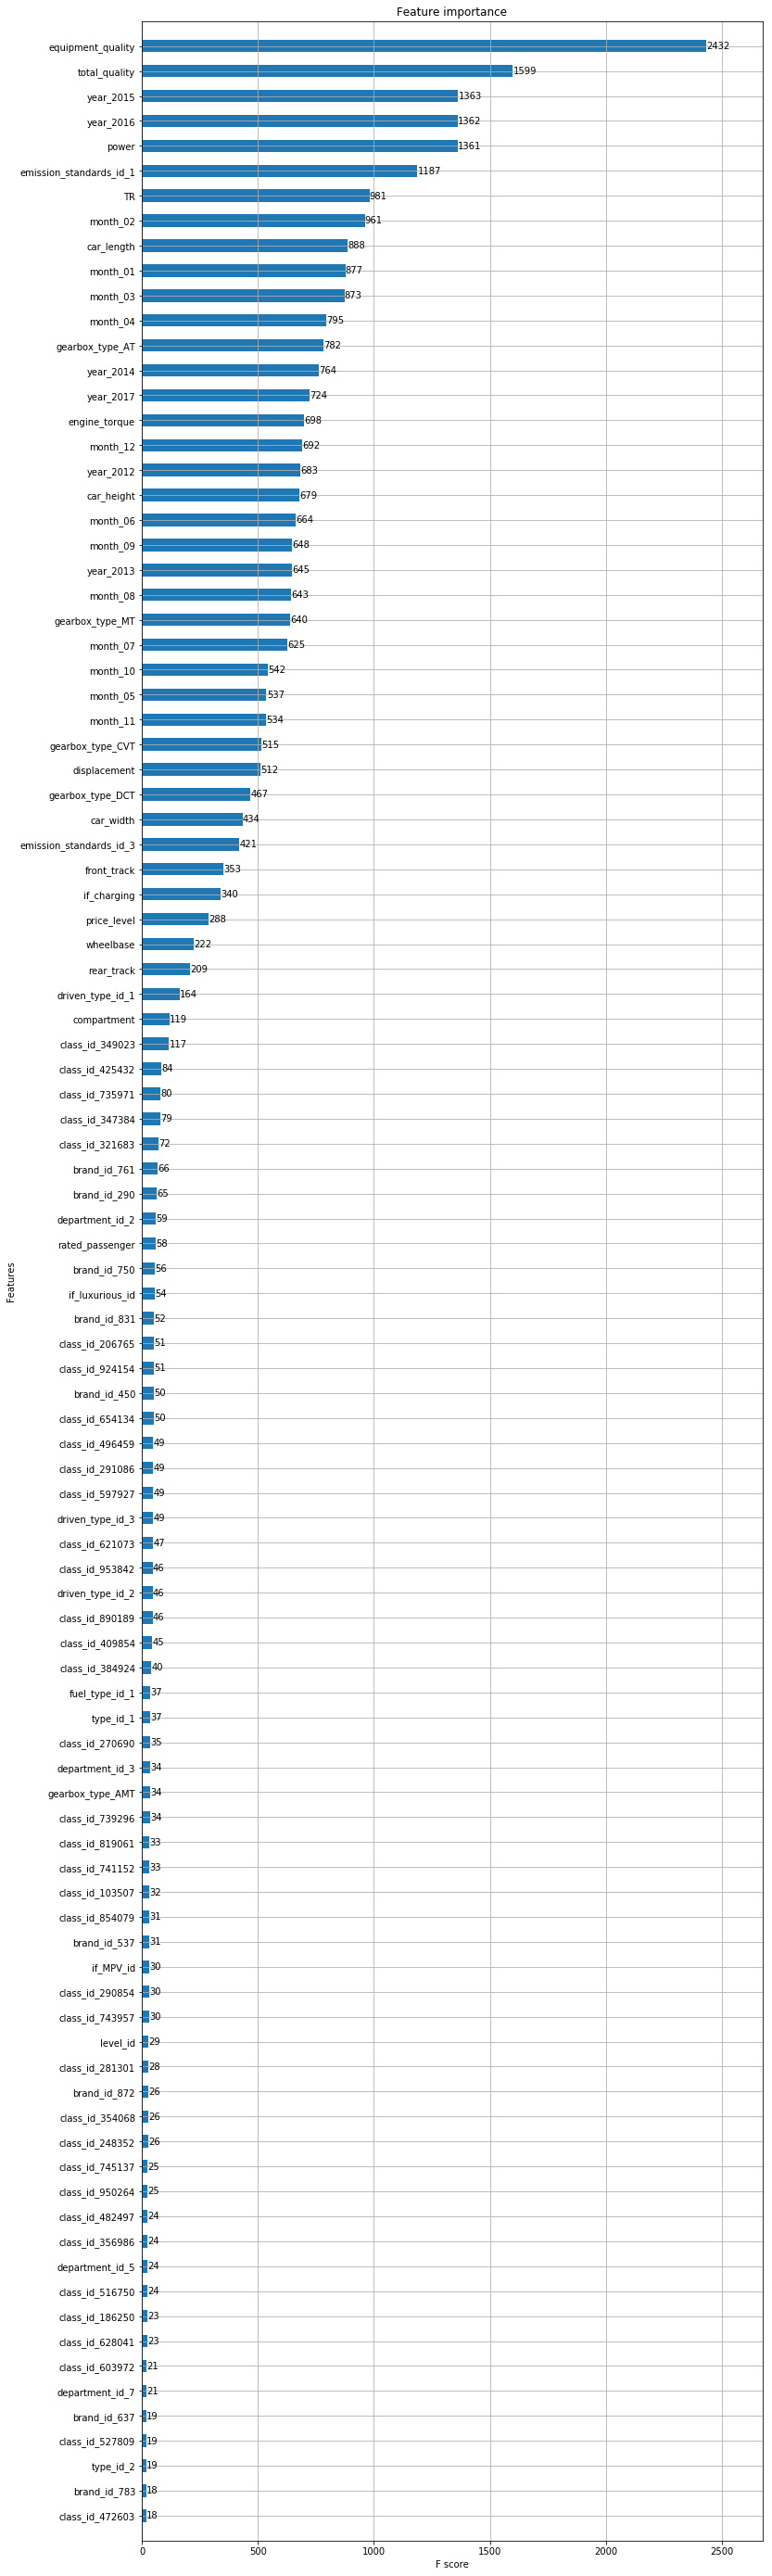

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(12, 50))
xgb.plot_importance(model, max_num_features=100, height=0.5, ax=ax)

### start to predict 201711 data

In [90]:
predict_df = pd.read_csv('../RawData/yancheng_testA_20171225.csv')
raw_df = df

In [91]:
facet_filter_pattern = re.compile('(sale_quantity)|(year)|(month)')
year_month_pattern = re.compile('(year)|(month)')

facet_columns = [c for c in raw_df.columns.values if not facet_filter_pattern.match(c)]
class_id_columns = [c for c in raw_df.columns.values if c.find('class_id') > -1]
year_month_columns = [c for c in raw_df.columns.values if year_month_pattern.match(c)]

In [105]:
year_month_columns

['year_2012',
 'year_2013',
 'year_2014',
 'year_2015',
 'year_2016',
 'year_2017',
 'month_01',
 'month_02',
 'month_03',
 'month_04',
 'month_05',
 'month_06',
 'month_07',
 'month_08',
 'month_09',
 'month_10',
 'month_11',
 'month_12']

In [116]:
unique_trainset_df = raw_df.drop_duplicates(facet_columns)
# unique_trainset_df['classid'] = unique_trainset_df.apply(lambda row: (row[class_id_columns]==1).idxmax(axis=1)[9:], axis=1).astype('int64')

In [194]:
__df = unique_trainset_df.drop(['sale_quantity'], axis=1)
__df = __df[data_train.columns.values]

In [195]:
__df.loc[:, 'year_2017'] = 1
__df.loc[:, 'year_2016'] = 0
__df.loc[:,'year_2015'] = 0
__df.loc[:,'year_2014'] = 0
__df.loc[:,'year_2013'] = 0
__df.loc[:,'year_2012'] = 0

In [196]:
__df.loc[:, 'month_12'] = 0
__df.loc[:, 'month_11'] = 1
__df.loc[:,'month_10'] = 0
__df.loc[:,'month_09'] = 0
__df.loc[:,'month_08'] = 0
__df.loc[:,'month_07'] = 0
__df.loc[:,'month_06'] = 0
__df.loc[:,'month_05'] = 0
__df.loc[:,'month_04'] = 0
__df.loc[:,'month_03'] = 0
__df.loc[:,'month_02'] = 0
__df.loc[:,'month_01'] = 0

In [197]:
dpred = xgb.DMatrix(__df)
__df_p = __df
__df_p['predicted_quantity'] = model.predict(dpred)

In [209]:
__df_p['class_id'] = __df_p.apply(lambda row:(row[class_id_columns]==1).idxmax(axis=1)[9:], axis=1 ).astype('int64')

In [212]:
__df_p[['class_id','predicted_quantity']]

,class_id,predicted_quantity
0,304458,74.788002
1,961362,62.932678
2,125403,92.426025
3,587678,53.932335
4,851857,93.715645
5,649213,80.816826
6,527809,30.521322
7,714860,99.312874
8,560265,53.733334
9,425432,19.891863


In [241]:
count_df = __df_p.groupby('class_id')['class_id'].count()

In [249]:
count_df[count_df.index == 653436]

class_id
653436    2
Name: class_id, dtype: int64

In [240]:
tmp_df = __df_p[__df_p.class_id.isin(count_df[count_df<5].index.values)][['class_id', 'predicted_quantity']]
tmp_df.groupby('class_id')['predicted_quantity'].sum()

class_id
169673    219.259308
194201     72.176720
340175    232.552017
359378     65.513535
376193    139.592621
612523    302.058289
653436    160.083435
842246    207.363159
948936    202.244873
Name: predicted_quantity, dtype: float32

## test with last submit